# Classification benchmark: PLN-Tree

In [1]:
from plntree.models import PLNTree
from plntree.utils.classifiers import DenseClassifier, RNNClassifier
from plntree.utils.jupyter_functions import *
from plntree.data.utils import numpy_dataset_to_torch_dataloader
import torch
import torch.optim as optim

2025-02-06 13:23:36.686474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 13:23:36.716771: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 13:23:36.894200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 13:23:36.894264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 13:23:36.927285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Metagenomics dataset

## Dataset import

In [2]:
seed = 0
# Select the taxonomic precision
precision = 'f'
prefix = f'metagenomics_classification_taxaL{precision}_s{seed}'

seed_all(seed)

In [3]:
from plntree.data import metagenomics_loader

raw_abundances, metadata = metagenomics_loader.load_raw_data(directory='./plntree/data/metagenomics')

In [4]:
diseases = ['t2d', 'ibd_ulcerative_colitis', 'cirrhosis', 'ibd_crohn_disease', 'cancer', 'obesity', 'leaness']
raw_abundances, metadata = metagenomics_loader.filter_diseases(raw_abundances, metadata, diseases)

In [5]:
# Filter out some taxa
filtered_taxa = ['k__Archaea', 'k__Eukaryota']
# Select the rarefaction offset
rarefaction_offset = 12
# Select the prevalence threshold (-1 for none)
prevalence = 1 / np.exp(rarefaction_offset)

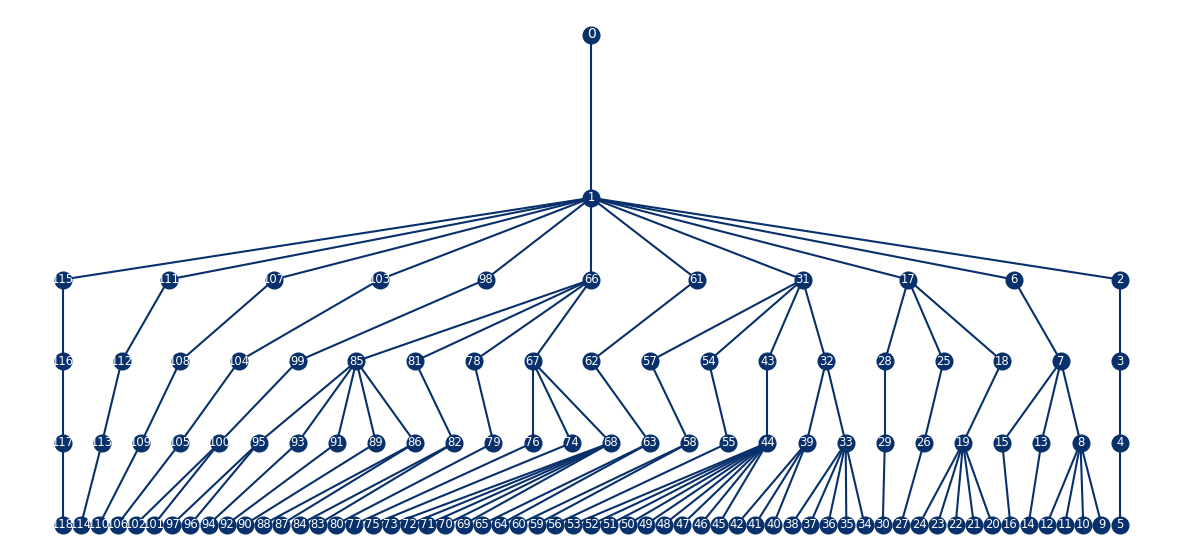

In [6]:
abundances = metagenomics_loader.raw_abundance_filter(raw_abundances, precision)
for taxon in filtered_taxa:
    abundances = metagenomics_loader.exclude_taxon(abundances, taxon)
if prevalence > 0:
    abundances = metagenomics_loader.prevalence_filter(abundances, threshold=prevalence)
abundances = metagenomics_loader.rarefy(abundances, rarefaction_offset, seed=seed)

taxonomy = metagenomics_loader.get_taxonomy(abundances)
taxonomy.plot(legend=False, title='')

In [7]:
from torch.utils.data import DataLoader, TensorDataset
# Select the offset layer
selected_layers = [2, -1]
K = list(taxonomy.getLayersWidth().values())[selected_layers[0]:]
X_base, patient_ids = metagenomics_loader.hierarchical_dataset(abundances, taxonomy, offset_layer=selected_layers[0])

# Select the batch size
batch_size = len(X_base)
seed_all(seed)
dataset = TensorDataset(X_base.to(dtype=torch.float64), X_base.to(dtype=torch.float64))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

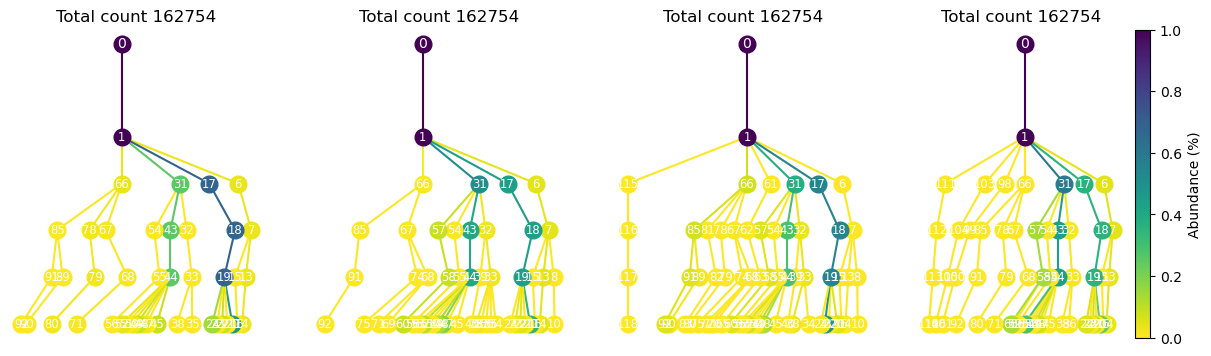

In [8]:
vizualize_samples(dataloader, taxonomy, autofill=True, seed=seed)
savefig('metagenomics_samples')

## Visualize the problem's difficulty with PCA

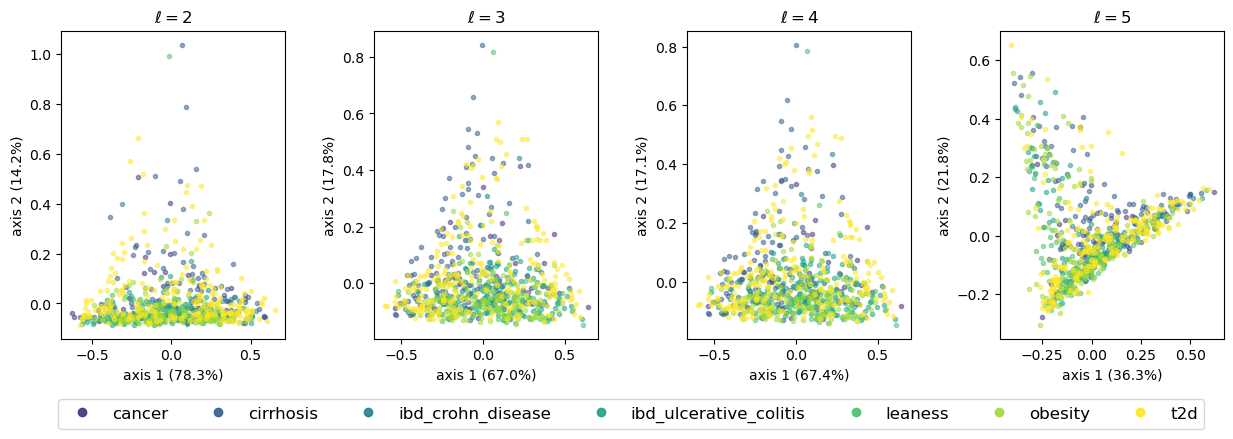

In [9]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease']
def plot_pca(Y_base, X_base):
    fig, axs = plt.subplots(1, len(K), figsize=(15, 4))
    colors = [matplotlib.cm.get_cmap('viridis')((i+1)/len(np.unique(Y_base))) for i, name in enumerate(np.unique(Y_base))]
    for layer, K_l in enumerate(K):
        X_l = X_base[:, layer, :K_l]
        pca = PCA(n_components=2, random_state=seed).fit(X_l)
        X_l_pca = pca.transform(X_l)
        for k, c in enumerate(np.unique(Y_base)):
            indexes = np.where(Y_base == c)
            axs[layer].set_title(f'$\ell = {layer + selected_layers[0]}$')
            axs[layer].plot(X_l_pca[indexes, 0], X_l_pca[indexes, 1], marker='.', linestyle='', color=colors[k], alpha=0.5)
            axs[layer].set_xlabel(f'axis 1 ({np.round(pca.explained_variance_ratio_[0] * 100, 1)}%)')
            axs[layer].set_ylabel(f'axis 2 ({np.round(pca.explained_variance_ratio_[1] * 100, 1)}%)')
    legend_handles = [
            mlines.Line2D([], [], marker='o', linestyle='', color=color, alpha=0.9, label=group)
            for color, group in zip(colors, np.unique(Y_base))
        ]
    legend = plt.legend(handles=legend_handles, fontsize="12", loc='lower center', bbox_to_anchor=(-1.65, -0.32), ncols=len(colors))
    plt.subplots_adjust(wspace=0.4)
plot_pca(Y_base, X_base / X_base[:, 0].sum(dim=-1, keepdims=True).unsqueeze(-1))
savefig(f'{prefix}_PCA_all_diseases')

In [10]:
n_classes = len(np.unique(Y_base))
n_classes

7

In [11]:
print(np.unique(Y_base, return_counts=True))

(array(['cancer', 'cirrhosis', 'ibd_crohn_disease',
       'ibd_ulcerative_colitis', 'leaness', 'obesity', 't2d'],
      dtype=object), array([ 48, 118,  25, 148,  89, 164, 223]))


## Preprocessing using PLN models

Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 919 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 908 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 899 iterations
Setting the offsets as the log of the sum of endog
Fitting a Pln model with full covariance model.
Initialization ...
Initialization finished
Tolerance 1e-08 reached in 852 iterations
Likelihood: -45823.94618296623


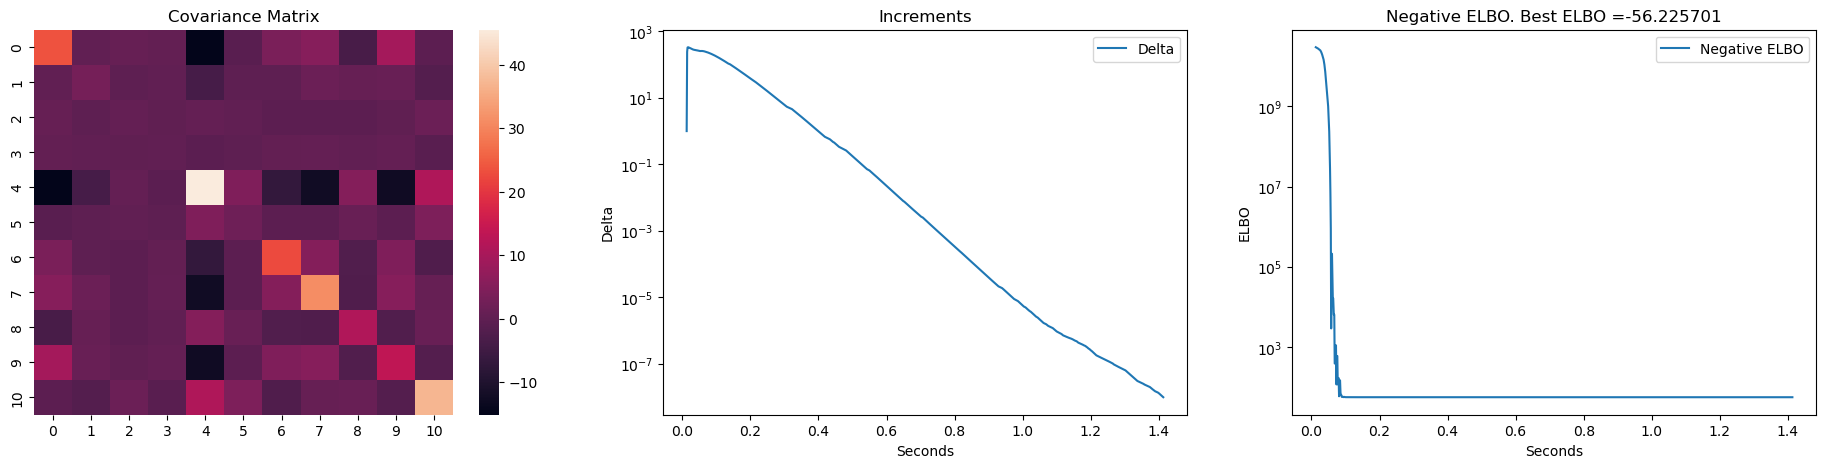

Likelihood: -81056.42355108261


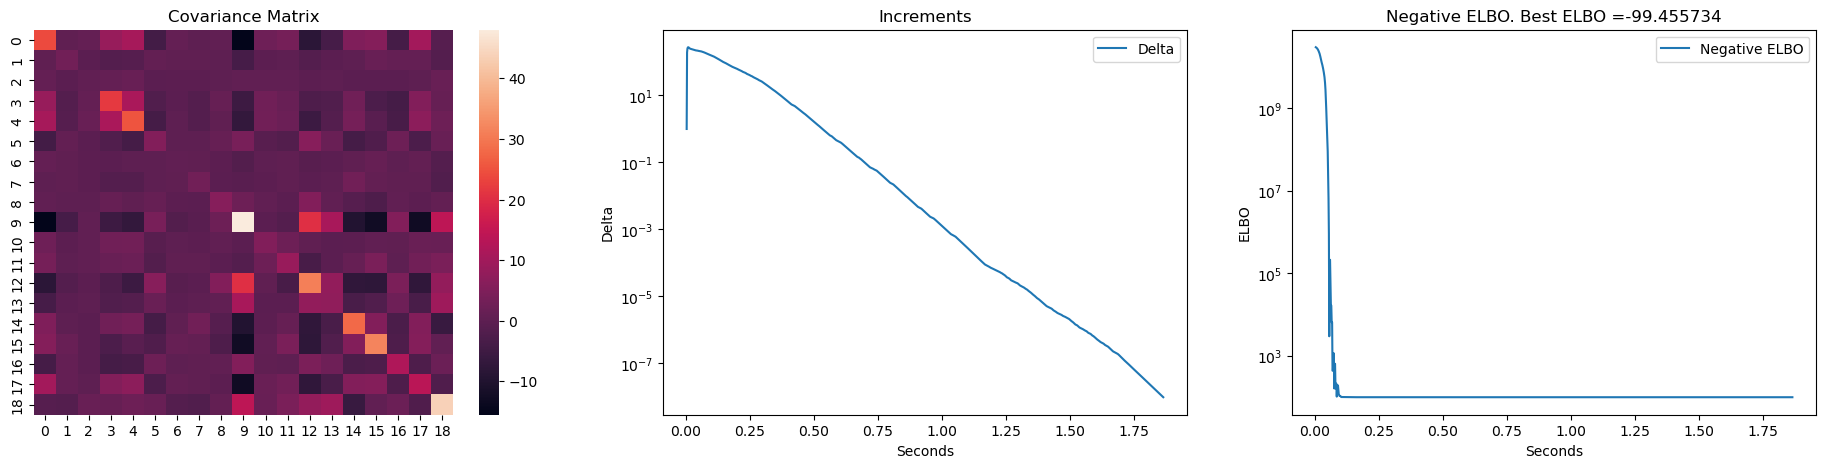

Likelihood: -96048.11932015419


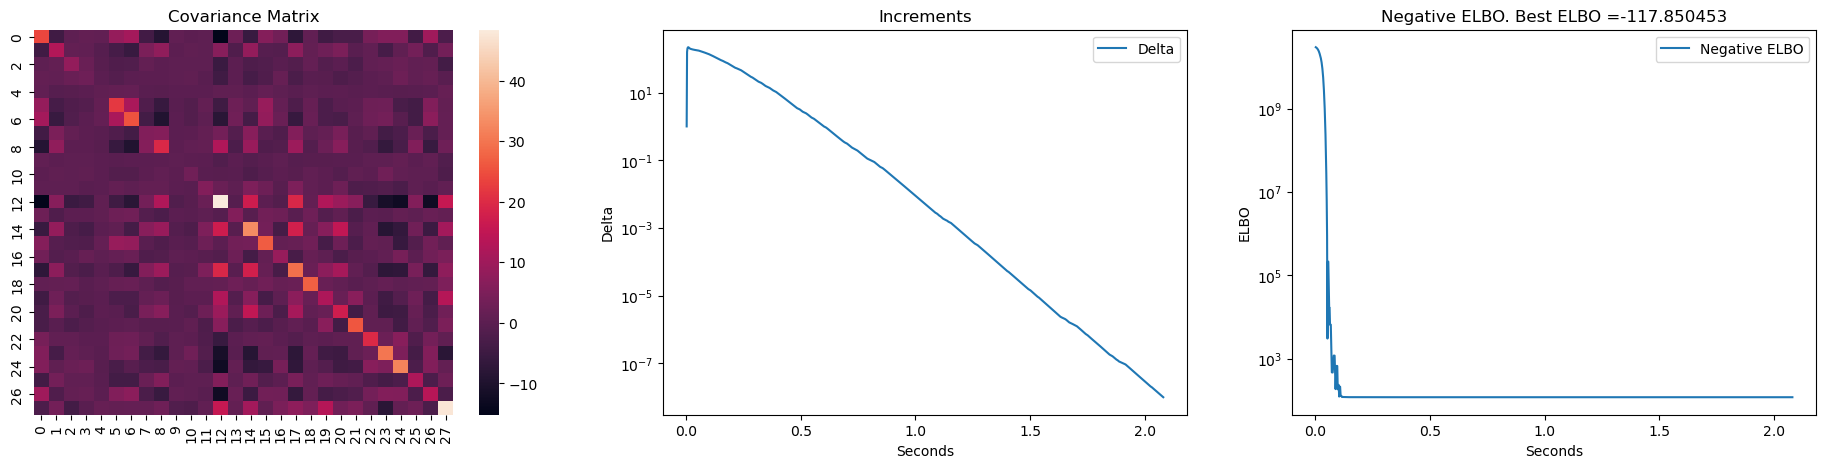

Likelihood: -182364.12615036964


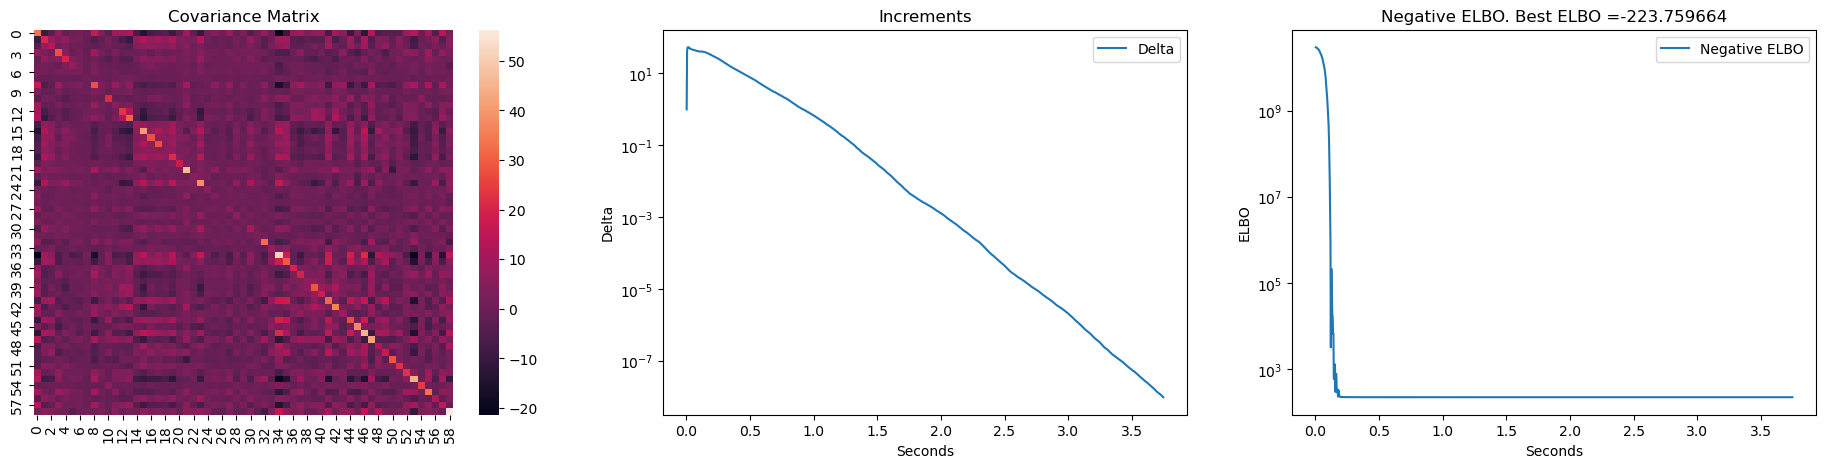

In [12]:
pln_layers = learn_pln(X_base, K, seed=seed)

In [13]:
def get_plntree_params_and_suffix(n_latent_layers, variational_approx, variational_approx_params):
    params = {
        'tree':taxonomy,
        'selected_layers':selected_layers,
        'diagonal_model':False,
        'variational_approx':variational_approx,
        'positive_fun':'softplus',
        'offset_method':'constant',
        'variational_approx_params':variational_approx_params,
        'n_latent_layers':n_latent_layers,
        'diag_smoothing_factor':1e-4
    }
    placeholder = variational_approx_params
    if variational_approx == 'mean_field':
        placeholder = variational_approx_params['n_variational_layers']
    suffix = f'latentlayers-{n_latent_layers}_varlayers-{placeholder}'
    return params, suffix

def learn_plntree_mean_field(params):
    estimator = PLNTree(**params, seed=seed)

    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=10.)

n_latent_layers = 1
n_variational_layers = 3
preprocessing = 'proportion'
print('Latents size', n_latent_layers)
print('Variational size', n_variational_layers)
variational_approx_params = {
    'n_variational_layers':n_variational_layers,
    'preprocessing': [preprocessing]
}
params, suffix = get_plntree_params_and_suffix(n_latent_layers, 'mean_field', variational_approx_params)
try:
    meanfield, meanfield_losses = load_pkl(prefix, f'mean_field_{preprocessing}_{suffix}')
except:
    meanfield, meanfield_losses = learn_plntree_mean_field(params)
    save_pkl((meanfield, meanfield_losses), prefix, f'mean_field_{preprocessing}_{suffix}')

Latents size 1
Variational size 3
Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_mean_field_proportion_latentlayers-1_varlayers-3.pkl


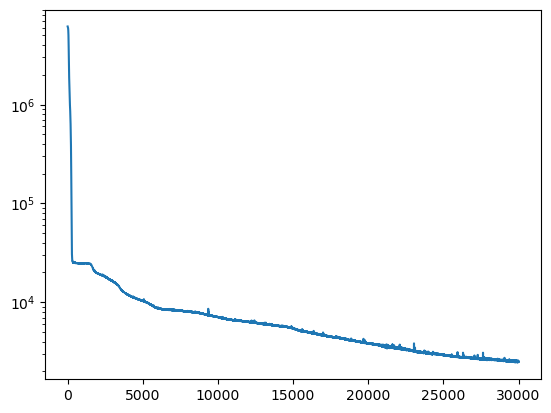

In [14]:
fig, axs = plt.subplots()
axs.plot(meanfield_losses)
axs.set_yscale('log')

In [15]:
preprocessing = 'proportion'
def learn_plntree(n_latent_layers, variational_approx, variational_approx_params):
    estimator = PLNTree(
        tree=taxonomy,
        selected_layers=selected_layers,
        diag_smoothing_factor=1e-4,
        positive_fun='softplus',
        offset_method='constant',
        identifiable=True,
        variational_approx=variational_approx,
        variational_approx_params=variational_approx_params,
        n_latent_layers=n_latent_layers,
        seed=seed
    )
    optimizer = optim.Adam(
        estimator.parameters(),
        lr=1e-3,
    )
    estimator.to(dtype=torch.float64)
    n_epoch = 30_000
    return estimator.fit(optimizer, dataloader, n_epoch=n_epoch, verbose=100, max_grad_norm=5.)

def embedder_params(embedder_type='GRU', embedding_size=16, n_embedding_layers=2, n_embedding_neurons=32, n_after_layers=2):
    params = {
        'embedder_type': embedder_type,
        'embedding_size': embedding_size,
        'n_embedding_layers': n_embedding_layers,
        'n_embedding_neurons': n_embedding_neurons,
        'n_after_layers': n_after_layers,
        'preprocessing': ['proportion']
    }
    name = f'Emb{embedder_type}-{n_embedding_layers}x{n_embedding_neurons}to{embedding_size}-{n_after_layers}'
    return name, params

n_latent_layers = 1
emb_name, variational_approx_params = embedder_params(
    embedding_size=32,
    n_embedding_layers=2,
    n_embedding_neurons=64,
    n_after_layers=2
)
try:
    backward, backward_losses = load_pkl(prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')
except:
    print('Learning PLN-Tree (residual backward)')
    print(variational_approx_params)
    backward, backward_losses = learn_plntree(n_latent_layers, 'residual_backward', variational_approx_params)
    save_pkl((backward, backward_losses), prefix, f'residual_backward_{preprocessing}_{n_latent_layers}-{emb_name}')

Loading file ./experiments/saves/metagenomics_classification_taxaLf_s0_residual_backward_proportion_1-EmbGRU-2x64to32-2.pkl


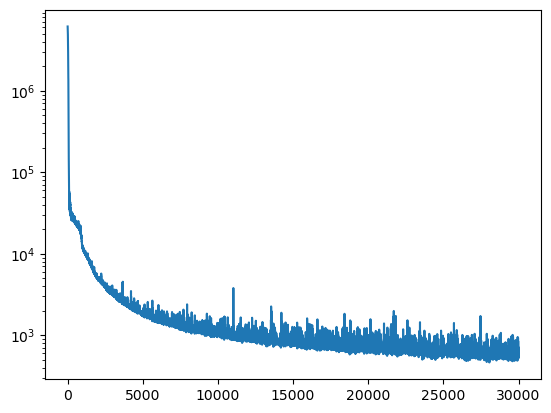

In [16]:
fig, axs = plt.subplots()
axs.plot(backward_losses)
axs.set_yscale('log')

In [17]:
n_repeat_sampling = 30
Z_meanfield = []
Z_backward = []
seed_all(seed)
for i in range(n_repeat_sampling):
    Z_meanfield += [meanfield.encode(X_base)[0]]
    Z_backward += [backward.encode(X_base)[0]]
Z_meanfield = torch.stack(Z_meanfield).mean(0)
Z_backward = torch.stack(Z_backward).mean(0)

In [18]:
Z_meanfield = meanfield.identify(Z_meanfield)
Z_backward = backward.identify(Z_backward)

In [20]:
Z_pln_enc = []
for i in range(n_repeat_sampling):
    Z_pln_enc += [generate_pln_data(pln_layers, 1, K, selected_layers, X_base, taxonomy, seed=seed)[-2]]
Z_pln_enc = torch.stack(Z_pln_enc).mean(0)

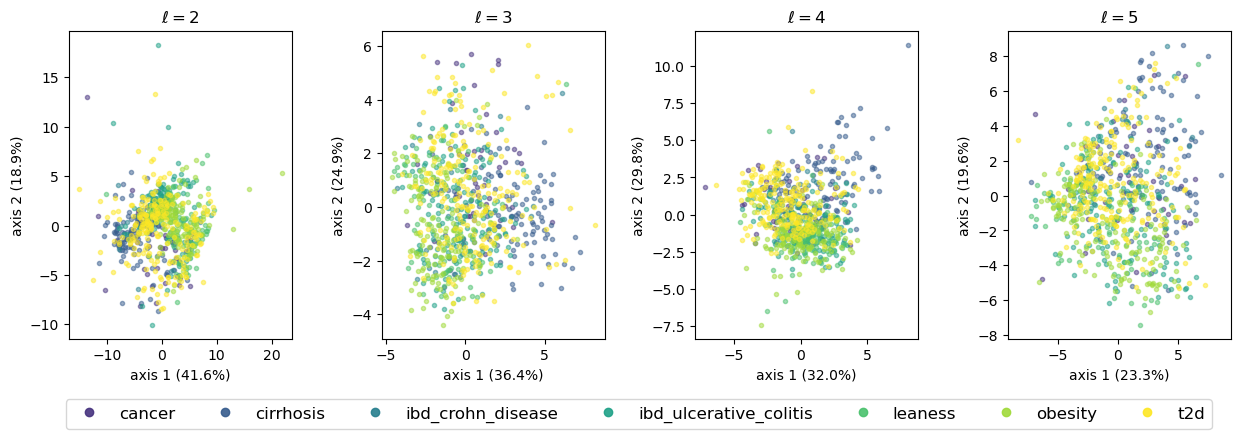

In [21]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
plot_pca(Y_base, Z_backward.detach())

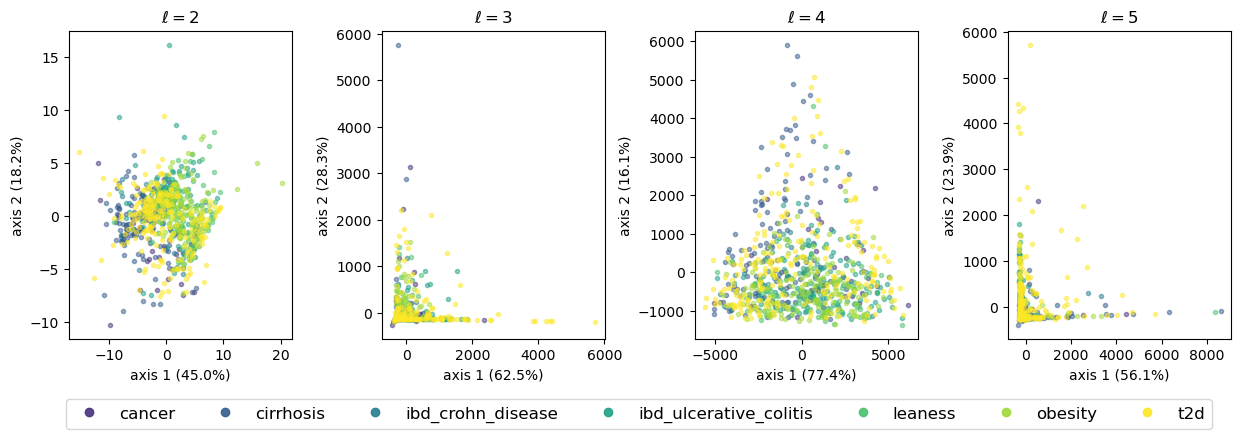

In [22]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

Y_base = metadata['disease'].copy()
prefix_labels = 'all_diseases-'
Z_plot = backward.latent_clr(Z_backward).detach()
plot_pca(Y_base, Z_plot)
savefig(f'{prefix}_PCA_all_diseases_latent_allocation')

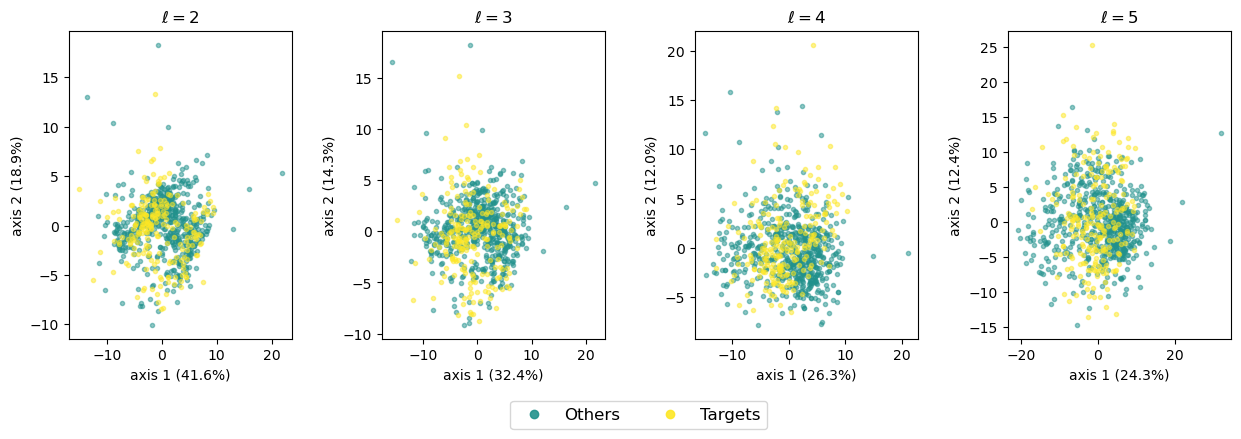

In [23]:
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import matplotlib

scenario = 't2d'

if scenario == 'ibd':
    filtered_labels = ['ibd_crohn_disease', 'ibd_ulcerative_colitis']
elif scenario == 'cirrhosis':
    filtered_labels = ['cirrhosis']
elif scenario == 'obesity':
    filtered_labels = ['obesity']
elif scenario == 'colorectal':
    filtered_labels = ['cancer']
elif scenario == 'leaness':
    filtered_labels = ['leaness']
elif scenario == 't2d':
    filtered_labels = ['t2d']
elif scenario == 't2d_obe':
    filtered_labels = ['t2d', 'obesity']
elif scenario == 'cirr_col':
    filtered_labels = ['cirrhosis', 'colorectal']
prefix_labels = ''
for label in filtered_labels:
    prefix_labels += f'-{label}'
Y_base = metadata['disease'].copy()
for i in range(len(Y_base)):
    if Y_base[i] not in filtered_labels:
        Y_base[i] = 'Others'
    else:
        Y_base[i] = 'Targets'

plot_pca(Y_base, torch.log(backward.latent_tree_counts(Z_backward)).detach())

In [24]:
n_classes = len(np.unique(Y_base))
n_classes

2

In [25]:
print(np.unique(Y_base, return_counts=True))

(array(['Others', 'Targets'], dtype=object), array([592, 223]))


## Benchmark models

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score

def train_test(X, y, train_indexes, test_indexes):
    X_train, y_train = X[train_indexes], y[train_indexes]
    X_test, y_test = X[test_indexes], y[test_indexes]
    return X_train, y_train, X_test, y_test

def bootstrap_train(X, y, model, params, n_repeats=10, n_cross_val=10, train_size=0.8, cross_val_size=0.2, seed=None, verbose=False):
    seed_all(seed)
    models = []
    indexes = np.arange(0, len(X))
    for i, (train_indexes, test_indexes) in enumerate(StratifiedShuffleSplit(n_splits=n_repeats, train_size=train_size).split(X, y)):
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        n_cv = int(cross_val_size * len(indices))
        X_cv, y_cv = X_train[indices[:n_cv]], y_train[indices[:n_cv]]
        X_train, y_train = X_train[indices[n_cv:]], y_train[indices[n_cv:]]
        assert((np.unique(y_train) == np.unique(y_test)).all())
        if verbose:
            print(f'Fitting Fold {i}...')
        models_cv = []
        performances = []
        for _ in range(n_cross_val):
            selected_params = {}
            for key, values in params.items():
                v = np.random.choice(values)
                if '(' in str(v):
                    v = np.fromstring(v[1:-1], sep=',').astype(np.int32)
                selected_params[key] = v
            benchmark = model(**selected_params).fit(X_train, y_train)
            y_pred = benchmark.predict(X_cv)
            models_cv += [benchmark]
            performances += [balanced_accuracy_score(y_pred, y_cv)]
        best = np.argmax(performances)
        models.append((models_cv[best], train_indexes, test_indexes))
    return models

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, RocCurveDisplay
import pandas as pd
from scipy import interp
from scipy.stats import mstats
import math

def performances(X, y, benchmarks, predict_args=None):
    if predict_args is None:
        predict_args = {}
    metrics = {
        'Balanced accuracy':balanced_accuracy_score,
        'Precision':lambda y_test, y_pred: precision_score(y_test, y_pred, average='weighted'),
        'Recall':lambda y_test, y_pred: recall_score(y_test, y_pred, average='weighted'),
        'F1':lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'),
    }
    results = {f'{key}':[] for key in metrics}
    conf_matrices = []
    auc_args = []
    pr_args = []
    auc_values = []
    auc_pr_values = []
    pr_values = []
    for model, train_indexes, test_indexes in benchmarks:
        X_train, y_train, X_test, y_test = train_test(X, y, train_indexes, test_indexes)
        y_proba = model.predict_proba(X_test, **predict_args)
        if len(predict_args) == 0:
            y_pred = model.predict(X_test)
        else:
            y_pred = model.predict(X_test, predict_args)
        for metric, metric_fun in metrics.items():
            results[metric].append(metric_fun(y_test, y_pred))
            
        conf_matrices.append(confusion_matrix(y_test, y_pred))
        
        if len(np.unique(y)) == 2:
            fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
            base_fpr = np.linspace(0, 1, 101)
            tpr_interp = interp(base_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            auc_args.append(tpr_interp)
            auc_values.append(auc(fpr, tpr))
            
            precisions, recalls, pr_thresh = precision_recall_curve(y_test, y_proba[:, 1])
            base_recalls = np.linspace(0, 1, 101)
            pre_interp = interp(base_recalls, np.flip(recalls), np.flip(precisions))
            pre_interp[0] = np.flip(precisions)[0]
            pr_args.append(pre_interp)
            auc_pr_values.append(auc(recalls, precisions))
            pr_values.append(average_precision_score(y_test, y_proba[:, 1]))
    if len(auc_values) > 0:
        results['ROC AUC'] = auc_values
    if len(pr_values) > 0:
        results['PR AUC'] = auc_pr_values
        #results['Averaged Precision'] = pr_values
    return results, conf_matrices, auc_args, pr_args

def performances_summary(X, y, benchmarks, name, predict_args=None, percentile=0.05):
    np.set_printoptions(suppress=True)
    results, conf_matrices, auc_args = performances(X, y, benchmarks, predict_args)
    print(f'------- Model summary {name} -------')
    for metric, res in results.items():
        print(f'{metric}:', np.round(np.mean(res), decimals=3), f'({np.round(np.std(res), decimals=3)})')
    cm = 0
    for matrix in conf_matrices:
        cm += matrix
    print('Mean normalized confusion matrix:')
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    labels = np.unique(y)
    if len(auc_args) > 0:
        fig, axs = plt.subplots()
        base_fpr = np.linspace(0, 1, 101)
        axs.plot([0, 1], [0, 1], color="navy", linestyle="--")
        axs.set_xlim([-0.01, 1.0])
        axs.set_ylim([-0.01, 1.05])
        axs.set_ylabel('True positive rate', fontsize=12)
        axs.set_xlabel('False positive rate', fontsize=12)
        axs.tick_params(labelright=True)
        axs.grid('True')

        roc_tpr_array = np.array(auc_args)
        for i in range(len(roc_tpr_array)):
            for j in range(roc_tpr_array.shape[1]):
                if math.isnan(roc_tpr_array[i][j]):
                    roc_tpr_array[i][j] = 0
        mean_tprs = roc_tpr_array.mean(axis=0)
        std_tprs = roc_tpr_array.std(axis=0)
        axs.plot(base_fpr, mean_tprs, 'b', label="Mean")
        
        quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
        axs.fill_between(base_fpr, quantiles[0], quantiles[1], color='b', alpha=0.1, label=f"CI {int(100*(1-percentile))}%")
        axs.legend()
    return pd.DataFrame(index=labels, columns=labels, data=cm).round(2)

In [28]:
import matplotlib
def multiple_performances_summary(X_dic, y, model, params, n_repeats=50, n_cross_val=50, train_size=0.8, cross_val_size=0.2, percentile=0.05, save_name=None, seed=None, verbose=False):
    df = None
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    axs[1].plot([0, 1], [0.5, 0.5], color="navy", linestyle="--")
    colors = [matplotlib.cm.get_cmap('plasma')(1e-8 + (i+1)/(len(X_dic)+.5)) for i in range(len(X_dic))]
    for k, (name, X) in enumerate(X_dic.items()):
        benchmarks = bootstrap_train(
            X, y,
            model, params, 
            n_cross_val=n_cross_val, 
            train_size=train_size, 
            cross_val_size=cross_val_size,
            seed=seed,
            n_repeats=n_repeats
        )
        np.set_printoptions(suppress=True)
        results, conf_matrices, auc_args, pre_args = performances(X, y, benchmarks)
        inputs = []
        metrics = []
        for metric, res in results.items():
            inputs.append(f'{np.round(np.mean(res), decimals=3)} ({np.round(np.std(res), decimals=3)})')
            metrics.append(metric)
        if df is None:
            df = pd.DataFrame(columns=metrics)
        df.loc[name] = inputs
        if len(auc_args) > 0:
            base_fpr = np.linspace(0, 1, 101)
            axs[0].set_xlim([-0.01, 1.0])
            axs[0].set_ylim([-0.01, 1.05])
            axs[0].set_ylabel('True positive rate', fontsize=12)
            axs[0].set_xlabel('False positive rate', fontsize=12)

            roc_tpr_array = np.array(auc_args)
            for i in range(len(roc_tpr_array)):
                for j in range(roc_tpr_array.shape[1]):
                    if math.isnan(roc_tpr_array[i][j]):
                        roc_tpr_array[i][j] = 0
            mean_tprs = roc_tpr_array.mean(axis=0)
            std_tprs = roc_tpr_array.std(axis=0)
            axs[0].plot(base_fpr, mean_tprs, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(roc_tpr_array, prob=[percentile, 1-percentile], axis=0)
            axs[0].fill_between(base_fpr, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
        if len(pre_args) > 0:
            base_recalls = np.linspace(0, 1, 101)
            axs[1].set_xlim([-0.01, 1.0])
            axs[1].set_ylim([-0.01, 1.05])
            axs[1].set_ylabel('Precision', fontsize=12)
            axs[1].set_xlabel('Recall', fontsize=12)

            precisions = np.array(pre_args)
            for i in range(len(precisions)):
                for j in range(precisions.shape[1]):
                    if math.isnan(precisions[i][j]):
                        precisions[i][j] = 0.
            mean_precisions = precisions.mean(axis=0)
            std_precisions = precisions.std(axis=0)
            axs[1].plot(base_recalls, mean_precisions, color=colors[k], label=name, alpha=0.7)

            quantiles = mstats.mquantiles(precisions, prob=[percentile, 1-percentile], axis=0)
            axs[1].fill_between(base_recalls, quantiles[0], quantiles[1], color=colors[k], alpha=0.1)
    #axs[0].legend()
    axs[0].grid('True')
    axs[1].legend()
    axs[1].grid('True')
    plt.tight_layout()
    if save_name is not None:
        savefig(f'{prefix}_{save_name}')
    return df.transpose()

In [29]:
# Raw data
X = X_base[:, -1, :] / X_base[:, 0].sum(dim=-1, keepdims=True)
y = Y_base.copy()
y[y == 'Targets'] = 1
y[y == 'Others'] = 0
y = y.astype(np.int32)
#y = y.factorize()[0]

In [30]:
def latent_tree_counts_partially_observed(self, X, layer, proportions=False, n_repeat=50, seed=seed):
        W = torch.zeros_like(X[:, layer, :self.K[layer]])
        X_ = X.clone()
        if proportions:
            X_ /= X_.sum(-1, keepdims=True)
        
        Z, O = self.encode(X, seed=seed)
        for i in range(1, n_repeat):
            Z_, O_ = self.encode(X)
            Z += Z_
            O += O_
        Z /= n_repeat
        O /= n_repeat
        Z[:, 0, :self.K[0]] += O.unsqueeze(-1)
        for parent in self.tree.getNodesAtDepth(layer + self.selected_layers[0] - 1):
            X_parent = X_[:, layer - 1, parent.layer_index].unsqueeze(-1)
            children_index = [child.layer_index for child in parent.children]
            if len(children_index) > 1:
                weights = torch.softmax(Z[:, layer, children_index], dim=-1)
                W[:, children_index] = X_parent * weights
            else:
                W[:, children_index] = X_parent
        return W

latent_tree_counts_partially_observed(backward, X_base, 3, proportions=True)

tensor([[0.0000e+00, 1.4427e-04, 6.3702e-04,  ..., 0.0000e+00, 2.0276e-04,
         0.0000e+00],
        [4.9154e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.9938e-04,
         0.0000e+00],
        [0.0000e+00, 4.5020e-05, 7.9910e-05,  ..., 0.0000e+00, 3.7480e-04,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.7968e-05, 2.3435e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.2450e-04, 2.5036e-04,  ..., 7.9875e-05, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.7118e-05, 2.5603e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], grad_fn=<CopySlices>)

In [31]:
def polp(self, X, Z, layer, proportions=False, seed=seed):
        W = torch.zeros_like(X[:, layer, :self.K[layer]])
        X_ = X.clone()
        if proportions:
            X_ /= X_.sum(-1, keepdims=True)
        for parent in self.tree.getNodesAtDepth(layer + self.selected_layers[0] - 1):
            X_parent = X_[:, layer - 1, parent.layer_index].unsqueeze(-1)
            children_index = [child.layer_index for child in parent.children]
            if len(children_index) > 1:
                weights = torch.softmax(Z[:, layer, children_index], dim=-1)
                W[:, children_index] = X_parent * weights
            else:
                W[:, children_index] = X_parent
        return W

In [32]:
def concat_layer(model, X, Z, layer):
    X_l = X[:, layer, :model.K[layer]].detach()
    Z_l = Z[:, layer, :model.K[layer]].detach()
    return torch.cat((X_l, Z_l), dim=-1)

In [33]:
def softmax_tree(self, Z):
    Z_soft = torch.zeros_like(Z)
    for layer, mask in enumerate(self.layer_masks):
        if layer == 0:
            Z_soft[:, layer, mask] = torch.softmax(Z[:, layer, mask], dim=-1)
        else:
            for parent in self.tree.getNodesAtDepth(layer + self.selected_layers[0] - 1):
                children_index = [child.layer_index for child in parent.children]
                if len(children_index) == 1:
                    Z_soft[:, layer, children_index] = 1.
                else:
                    Z_soft[:, layer, children_index] =  torch.softmax(Z[:, layer, children_index], dim=-1)
    return Z_soft

In [34]:
X_prop = X_base / X_base.sum(-1, keepdims=True)

In [50]:
Z_backward[:, 0, :backward.K[0]] = Z_backward[:, 0, :backward.K[0]] - Z_backward[:, 0, :backward.K[0]].mean(-1, keepdims=True)

In [65]:
def ilr_transform_groups(X, groups):
    """
    Perform an ilr transformation using a grouping structure provided by `groups`.
    
    Each row of X (of shape (n, K)) is a composition. The vector `groups` (of length K) 
    assigns each part to a group using ordinal values. The unique sorted groups define a 
    sequential binary partition of the parts. For k=1,...,m-1 (with m the number 
    of unique groups) we define:
    
        A = indices where groups <= unique_groups[k-1]
        B = indices where groups > unique_groups[k-1]
    
    and the k-th balance coordinate is defined as:
    
        y_k = sqrt((r * s) / (r+s)) * ( (1/r) * sum(log(x_i) for i in A) - (1/s) * sum(log(x_j) for j in B) ),
    
    where r = |A| and s = |B|.
    
    Args:
        X (torch.Tensor): Tensor of shape (n, K) with compositions (positive entries that sum to one).
        groups (torch.Tensor or list-like): Vector of length K with ordinal group labels.
    
    Returns:
        torch.Tensor: Tensor of shape (n, m-1) with the ilr-transformed data.
    """
    # Ensure groups is a torch tensor
    if not torch.is_tensor(groups):
        groups = torch.tensor(groups)
        
    # Get the sorted unique groups
    unique_groups = torch.unique(groups, sorted=True)
    m = unique_groups.numel()
    n, K = X.shape

    # Take logs of the compositions
    logX = torch.log(X + 1e-36)
    
    # Allocate output tensor for m-1 balances
    out = torch.empty((n, m - 1), dtype=X.dtype, device=X.device)
    
    # Build balances based on the sequential binary partition induced by the groups
    for k in range(1, m):
        # Define the threshold: all parts with group <= unique_groups[k-1] go to A
        threshold = unique_groups[k-1]
        A_indices = (groups <= threshold).nonzero(as_tuple=True)[0]
        B_indices = (groups > threshold).nonzero(as_tuple=True)[0]
        
        r = A_indices.numel()
        s = B_indices.numel()
        if r == 0 or s == 0:
            raise ValueError("The grouping does not allow for a valid balance (one of the groups is empty).")
        
        # Compute the normalization constant ensuring orthonormality
        coef = torch.sqrt(torch.tensor((r * s) / (r + s), dtype=X.dtype, device=X.device))
        
        # Compute the mean of the logs in groups A and B for every sample
        mean_A = torch.mean(logX[:, A_indices], dim=1)
        mean_B = torch.mean(logX[:, B_indices], dim=1)
        
        # Compute the k-th balance coordinate
        out[:, k-1] = coef * (mean_A - mean_B)
    
    return out

groups = []
for i, parent in enumerate(taxonomy.getNodesAtDepth(4)):
    groups += [i]*len(parent.children)
assert(len(groups) == backward.K[-1])

In [76]:
from skbio.stats.composition import ilr

In [78]:
from plntree.utils.functions import clr_transform
# Preprocessed Z
#Z_meanfield_alloc = meanfield.latent_tree_counts(Z_meanfield, proportions=True)[:, -1, :].detach()
#Z_backward_alloc = backward.latent_tree_counts(Z_backward, proportions=True)[:, -1, :].detach()
Z_meanfield_polp = polp(backward, X_base, Z_backward, 3, proportions=True).detach()
Z_backward_polp = polp(meanfield, X_base, Z_meanfield, 3, proportions=True).detach()
#Z_meanfield_polp = latent_tree_counts_partially_observed(backward, X_base, 3, proportions=True).detach()
#Z_backward_polp = latent_tree_counts_partially_observed(meanfield, X_base, 3, proportions=True).detach()

Z_meanfield_lp = meanfield.latent_tree_counts(Z_meanfield, proportions=True)[:, -1, :].detach()
Z_backward_lp = backward.latent_tree_counts(Z_backward, proportions=True)[:, -1, :].detach()
Z_backward_lc = backward.latent_tree_counts(Z_backward, proportions=False)[:, -1, :].detach()

#Z_meanfield_alloc = torch.log(Z_meanfield_alloc)
#Z_backward_alloc = torch.log(Z_backward_alloc)

# Normalize PLN to avoid spurious effects of the ofvfset
Z_pln = Z_pln_enc[:, -1, :].clone() 
# Apply CLR transform to all the compositional data
Z_backward_polpclr = clr_transform(Z_backward_polp)
Z_meanfield_polpclr = clr_transform(Z_meanfield_polp)
Z_backward_lpclr = clr_transform(Z_backward_lp)
Z_meanfield_lpclr = clr_transform(Z_meanfield_lp)
Z_backward_lcclr = clr_transform(Z_backward_lc)
X_clr = clr_transform(X)


Z_backward_lpilr = ilr(Z_backward_lp) #ilr_transform_groups(Z_backward_lp, groups)
X_ilr = ilr(X + 1e-36) #ilr_transform_groups(X_prop[:, -1, :], groups)

X_L_Z_L_backward = concat_layer(backward, X_prop, softmax_tree(backward, Z_backward), -1)
X_L_Z_L_MF = concat_layer(meanfield, X_prop, softmax_tree(meanfield, Z_meanfield), -1)

X_dic = {
    'raw':X, 
    'CLR': X_clr,
    'ILR': X_ilr,
    'PLN':Z_pln, 
    'Proj-PLN':clr_transform(torch.softmax(Z_pln, dim=-1)), 
    'LP-CLR (MF)':Z_meanfield_lpclr, 
    'LP-CLR':Z_backward_lpclr, 
    'LP-ILR':Z_backward_lpilr, 
    #'POLP-CLR':Z_backward_polpclr, 
    #'POLP-CLR (MF)':Z_meanfield_polpclr, 
    #'Cat(X,soft(Z))': X_L_Z_L_backward,
    #'Cat(X,soft(Z)) (MF)': X_L_Z_L_MF,
    #'Cat(X,LP-CLR)': concat_layer(backward, X_prop, Z_backward_lpclr.unsqueeze(1), -1),
    #'Cat(X,LP-CLR) (MF)': concat_layer(meanfield, X_prop, Z_meanfield_lpclr.unsqueeze(1), -1),
    'Proj-PLN + LP-CLR': concat_layer(backward, Z_pln.unsqueeze(1), Z_backward_lpclr.unsqueeze(1), -1),
    #'Cat(PLN,LP-CLR) (MF)': concat_layer(backward, Z_pln.unsqueeze(1), Z_meanfield_lpclr.unsqueeze(1), -1),
}

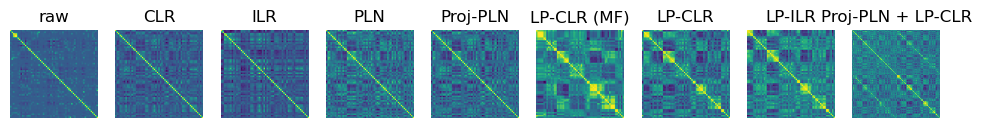

In [79]:
def estimate_covariance_matrix(X):
    X_centered = X - X.mean(dim=0, keepdim=True)
    covariance_matrix = (X_centered.T @ X_centered) / (X_centered.size(0) - 1)
    return covariance_matrix

def to_correlation_matrix(Sigma):
    if type(Sigma) == torch.Tensor:
        D_inv = torch.diag(1 / np.sqrt(torch.diag(Sigma)))
    else:
        D_inv = np.diag(1 / np.sqrt(np.diag(Sigma)))
    corr = D_inv @ Sigma @ D_inv
    return corr

fig, axs = plt.subplots(1, len(X_dic), figsize=(12, 4))
for i, (key, V) in enumerate(X_dic.items()):
    axs[i].imshow(to_correlation_matrix(estimate_covariance_matrix(torch.tensor(V))))
    axs[i].set_title(key)
    axs[i].axis('off')

### Logistic Regression

,raw,CLR,ILR,PLN,Proj-PLN,LP-CLR (MF),LP-CLR,LP-ILR,Proj-PLN + LP-CLR
Balanced accuracy,0.505 (0.008),0.686 (0.035),0.669 (0.038),0.672 (0.048),0.688 (0.048),0.661 (0.065),0.688 (0.046),0.678 (0.047),0.686 (0.043)
Precision,0.613 (0.119),0.76 (0.027),0.742 (0.026),0.746 (0.034),0.765 (0.034),0.744 (0.036),0.767 (0.028),0.765 (0.031),0.757 (0.03)
Recall,0.726 (0.005),0.762 (0.029),0.738 (0.026),0.749 (0.033),0.768 (0.03),0.741 (0.029),0.765 (0.028),0.767 (0.031),0.759 (0.029)
F1,0.615 (0.01),0.756 (0.025),0.734 (0.021),0.743 (0.033),0.76 (0.03),0.729 (0.033),0.756 (0.026),0.755 (0.03),0.754 (0.028)
ROC AUC,0.646 (0.049),0.798 (0.032),0.764 (0.031),0.779 (0.038),0.811 (0.037),0.762 (0.044),0.792 (0.036),0.788 (0.038),0.796 (0.033)
PR AUC,0.414 (0.064),0.596 (0.058),0.543 (0.054),0.582 (0.063),0.628 (0.067),0.521 (0.058),0.581 (0.063),0.582 (0.068),0.598 (0.061)


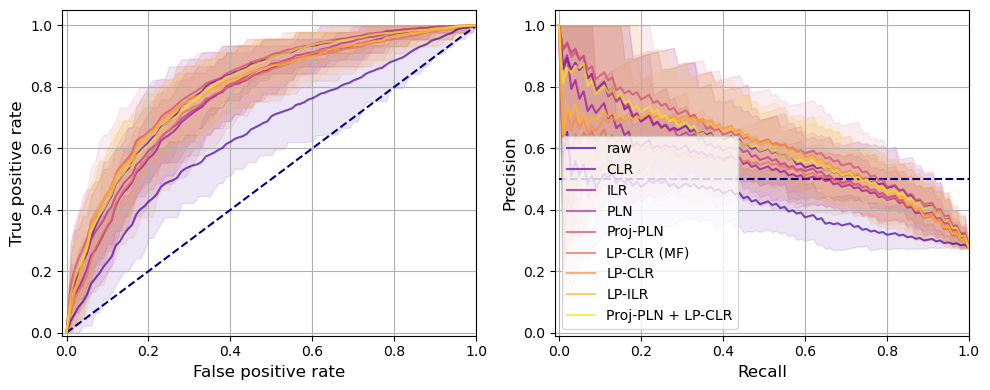

In [80]:
from sklearn.linear_model import LogisticRegression

benchmark_params = {
    'penalty': ['l2'],
    'C':[0.01, 0.05, 0.1, 0.3, 0.6, 1, 1.5, 2],
    'class_weight':['balanced', None]
}
multiple_performances_summary(
    X_dic,
    y,
    LogisticRegression, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_logistic_regression'
)

### Random Forest

,raw,CLR,ILR,PLN,Proj-PLN,LP-CLR (MF),LP-CLR,LP-ILR,Proj-PLN + LP-CLR
Balanced accuracy,0.652 (0.072),0.619 (0.055),0.554 (0.045),0.597 (0.061),0.598 (0.059),0.637 (0.058),0.648 (0.063),0.64 (0.064),0.649 (0.063)
Precision,0.809 (0.054),0.79 (0.041),0.724 (0.088),0.783 (0.064),0.771 (0.046),0.779 (0.04),0.8 (0.037),0.799 (0.041),0.808 (0.038)
Recall,0.799 (0.038),0.779 (0.027),0.743 (0.021),0.77 (0.03),0.767 (0.028),0.78 (0.029),0.792 (0.032),0.788 (0.034),0.797 (0.032)
F1,0.758 (0.064),0.731 (0.049),0.668 (0.046),0.71 (0.059),0.711 (0.055),0.743 (0.046),0.753 (0.055),0.747 (0.057),0.757 (0.055)
ROC AUC,0.882 (0.037),0.837 (0.044),0.773 (0.056),0.858 (0.047),0.839 (0.035),0.811 (0.042),0.844 (0.034),0.845 (0.037),0.868 (0.033)
PR AUC,0.751 (0.069),0.68 (0.062),0.565 (0.083),0.688 (0.086),0.663 (0.061),0.644 (0.078),0.695 (0.067),0.696 (0.069),0.727 (0.066)


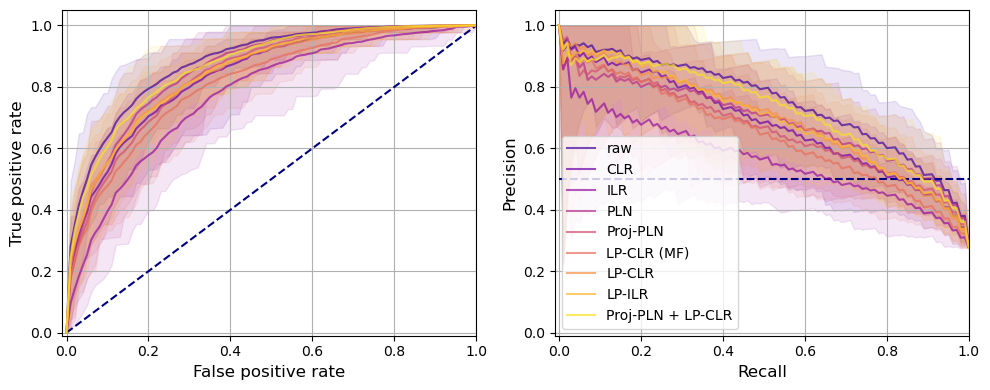

In [81]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators': [40, 100, 150],
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 3, 5, 10, 30],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 4]
}
multiple_performances_summary(
    X_dic,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest'
)

#### RandomForest specifics

,Raw $\ell=6$,PLN $\ell=2$,PLN $\ell=3$,PLN $\ell=4$,PLN $\ell=5$
accuracy,0.844 (0.016),0.813 (0.021),0.813 (0.017),0.814 (0.013),0.824 (0.016)
precision,0.857 (0.021),0.795 (0.038),0.805 (0.038),0.815 (0.029),0.833 (0.028)
recall,0.844 (0.016),0.813 (0.021),0.813 (0.017),0.814 (0.013),0.824 (0.016)
F1,0.81 (0.024),0.775 (0.028),0.766 (0.025),0.763 (0.021),0.777 (0.026)
balanced accuracy,0.647 (0.035),0.605 (0.039),0.588 (0.032),0.583 (0.027),0.6 (0.035)
ROC AUC,0.917 (0.021),0.803 (0.038),0.85 (0.029),0.855 (0.027),0.89 (0.02)
PR AUC,0.794 (0.05),0.558 (0.079),0.613 (0.074),0.643 (0.058),0.729 (0.046)
Averaged Precision,0.792 (0.049),0.563 (0.075),0.617 (0.069),0.643 (0.057),0.728 (0.044)


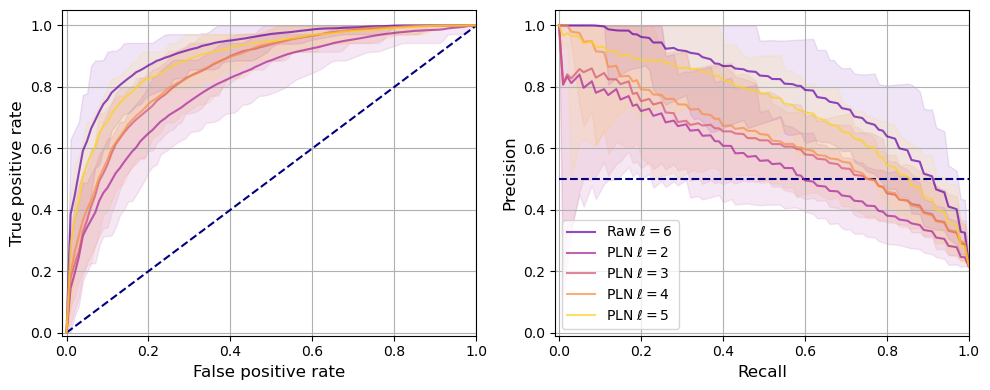

In [32]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced'
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN $\ell={i+selected_layers[0]}$'] = Z_pln_enc[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN'
)

,Raw $\ell=6$,PLN-Tree (backward) $\ell=2$,PLN-Tree (backward) $\ell=3$,PLN-Tree (backward) $\ell=4$,PLN-Tree (backward) $\ell=5$
accuracy,0.844 (0.016),0.806 (0.017),0.801 (0.015),0.802 (0.013),0.809 (0.016)
precision,0.857 (0.021),0.784 (0.037),0.779 (0.042),0.783 (0.039),0.793 (0.036)
recall,0.844 (0.016),0.806 (0.017),0.801 (0.015),0.802 (0.013),0.809 (0.016)
F1,0.81 (0.024),0.76 (0.023),0.747 (0.022),0.748 (0.021),0.761 (0.024)
balanced accuracy,0.647 (0.035),0.583 (0.03),0.565 (0.028),0.566 (0.026),0.583 (0.03)
ROC AUC,0.917 (0.021),0.775 (0.035),0.773 (0.035),0.793 (0.035),0.842 (0.03)
PR AUC,0.794 (0.05),0.518 (0.075),0.502 (0.078),0.521 (0.066),0.587 (0.068)
Averaged Precision,0.792 (0.049),0.524 (0.071),0.509 (0.072),0.528 (0.062),0.591 (0.065)


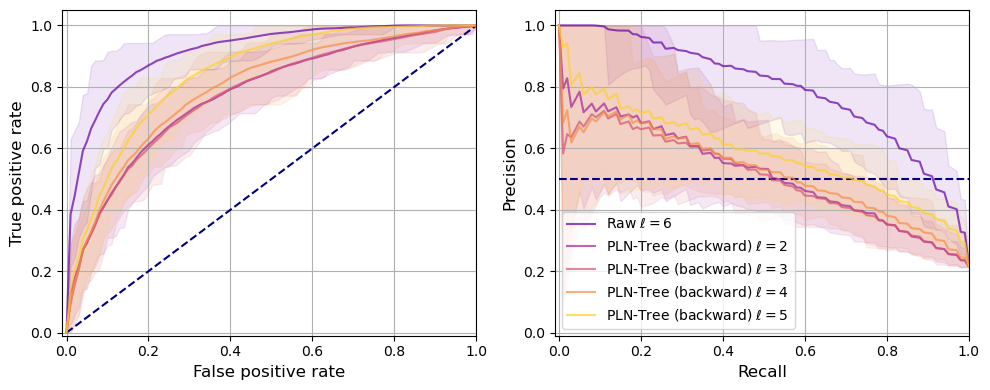

In [33]:
from sklearn.ensemble import RandomForestClassifier

benchmark_params = {
    'n_estimators':100,
    'class_weight':'balanced'
}
X_dic_layers = {'Raw $\ell=6$': X}
for i in range(len(K)):
    X_dic_layers[f'PLN-Tree (backward) $\ell={i+selected_layers[0]}$'] = backward.latent_tree_allocation(Z_backward).detach()[:, i, :]
multiple_performances_summary(
    X_dic_layers,
    y,
    RandomForestClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_randomforest_PLN-Tree_backward'
)

### SVM

,raw,CLR,ILR,PLN,Proj-PLN,LP-CLR (MF),LP-CLR,LP-ILR,Proj-PLN + LP-CLR
Balanced accuracy,0.505 (0.02),0.688 (0.043),0.672 (0.046),0.672 (0.05),0.698 (0.045),0.61 (0.075),0.674 (0.045),0.67 (0.046),0.69 (0.037)
Precision,0.554 (0.08),0.755 (0.032),0.741 (0.034),0.744 (0.035),0.761 (0.031),0.723 (0.049),0.765 (0.03),0.763 (0.029),0.756 (0.027)
Recall,0.72 (0.019),0.751 (0.032),0.734 (0.036),0.736 (0.035),0.75 (0.033),0.732 (0.023),0.772 (0.03),0.77 (0.031),0.75 (0.033)
F1,0.611 (0.01),0.749 (0.03),0.733 (0.033),0.734 (0.033),0.75 (0.03),0.698 (0.04),0.758 (0.031),0.755 (0.031),0.749 (0.029)
ROC AUC,0.612 (0.119),0.781 (0.032),0.753 (0.04),0.769 (0.04),0.793 (0.036),0.761 (0.036),0.786 (0.037),0.784 (0.04),0.787 (0.034)
PR AUC,0.409 (0.1),0.575 (0.06),0.538 (0.058),0.569 (0.068),0.606 (0.065),0.52 (0.064),0.581 (0.064),0.571 (0.068),0.595 (0.057)


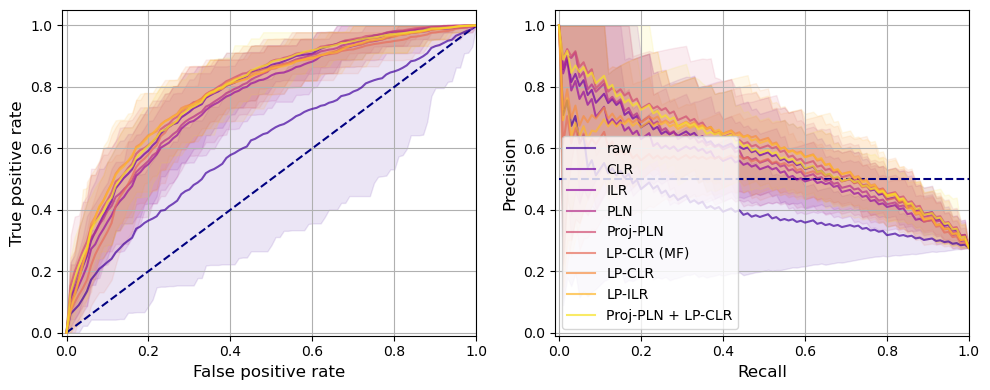

In [82]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':[True],
    'kernel':['linear'],
    'C':[0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1.1, 1.5],
    'class_weight':['balanced', None]
}
multiple_performances_summary(
    X_dic,
    y,
    SVC, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_SVM'
)

,raw,CLR,PLN,Proj-PLN,LP-CLR (MF),LP-CLR,Proj-PLN + LP-CLR
Balanced accuracy,0.521 (0.03),0.572 (0.092),0.532 (0.056),0.58 (0.104),0.538 (0.06),0.588 (0.104),0.566 (0.098)
Precision,0.71 (0.106),0.764 (0.09),0.667 (0.112),0.748 (0.099),0.706 (0.119),0.742 (0.108),0.706 (0.11)
Recall,0.729 (0.009),0.747 (0.026),0.732 (0.012),0.739 (0.019),0.739 (0.02),0.754 (0.031),0.742 (0.024)
F1,0.633 (0.027),0.671 (0.059),0.64 (0.037),0.668 (0.058),0.647 (0.047),0.684 (0.07),0.663 (0.061)
ROC AUC,0.677 (0.124),0.843 (0.044),0.803 (0.082),0.839 (0.087),0.755 (0.142),0.845 (0.037),0.822 (0.113)
PR AUC,0.469 (0.111),0.674 (0.08),0.571 (0.092),0.659 (0.1),0.558 (0.128),0.676 (0.071),0.616 (0.112)


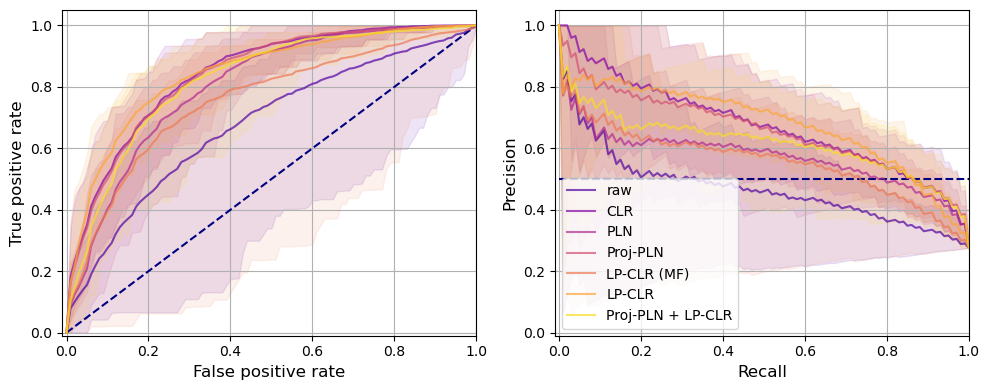

In [103]:
from sklearn.svm import SVC

benchmark_params = {
    'probability':[True],
    'kernel':['poly'],
    'degree':[1, 2, 4, 6, 10],
    'C':[0.01, 0.05, 0.1, 0.3, 0.5],
    'class_weight':['balanced', None]
}
multiple_performances_summary(
    X_dic,
    y,
    SVC, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_SVM'
)

### Neural network

,raw,CLR,ILR,PLN,Proj-PLN,LP-CLR (MF),LP-CLR,LP-ILR,Proj-PLN + LP-CLR
Balanced accuracy,0.676 (0.047),0.732 (0.04),0.67 (0.041),0.711 (0.033),0.733 (0.039),0.694 (0.042),0.75 (0.042),0.756 (0.046),0.742 (0.036)
Precision,0.76 (0.037),0.797 (0.03),0.755 (0.035),0.78 (0.026),0.798 (0.029),0.775 (0.031),0.808 (0.031),0.813 (0.036),0.804 (0.027)
Recall,0.77 (0.032),0.802 (0.029),0.767 (0.034),0.787 (0.026),0.805 (0.025),0.784 (0.027),0.812 (0.029),0.817 (0.034),0.808 (0.026)
F1,0.759 (0.034),0.797 (0.03),0.755 (0.034),0.781 (0.026),0.799 (0.028),0.773 (0.03),0.808 (0.03),0.814 (0.035),0.804 (0.026)
ROC AUC,0.787 (0.039),0.847 (0.032),0.793 (0.048),0.832 (0.032),0.859 (0.027),0.783 (0.035),0.842 (0.031),0.851 (0.035),0.86 (0.031)
PR AUC,0.607 (0.064),0.691 (0.058),0.6 (0.079),0.648 (0.057),0.696 (0.048),0.615 (0.069),0.704 (0.063),0.715 (0.075),0.711 (0.062)


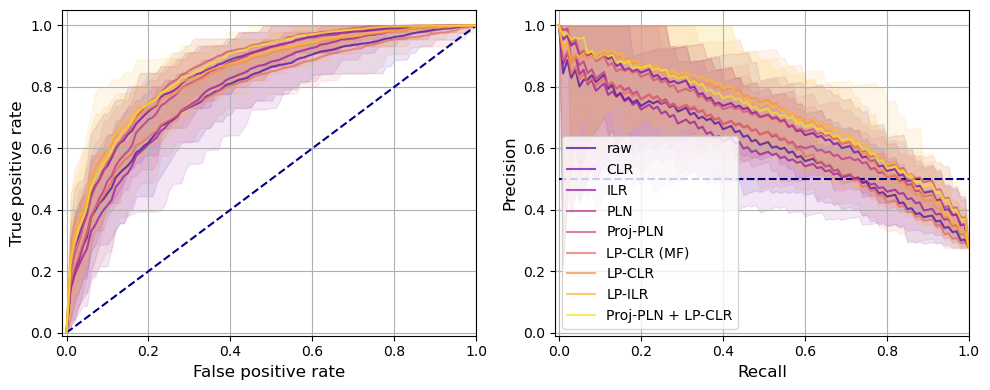

In [83]:
from sklearn.neural_network import MLPClassifier

benchmark_params = {
    'hidden_layer_sizes':[
        "(256, 256, 256, 124)", 
        "(256, 256, 256)", 
        "(256, 256, 124)", 
        "(124, 124, 64)", 
        "(64, 64, 32)", 
        "(32, 32, 32)",
        "(32, 32, 16)"
    ],
}
multiple_performances_summary(
    X_dic,
    y,
    MLPClassifier, benchmark_params,
    seed=seed,
    save_name=f'{prefix_labels}_ROC_MLP'
)